In [17]:
import networkx as nx
seed=1000           # seed the graph for reproducibility, you should be doing this  
G= nx.gnp_random_graph (8, .3, seed=seed )       # here we create a random binomial graph with 10 nodes and an average (expected) connectivity of 10*.3= 3.
print ( G.nodes() )

[0, 1, 2, 3, 4, 5, 6, 7]


In [15]:
print(G.edges())

[]


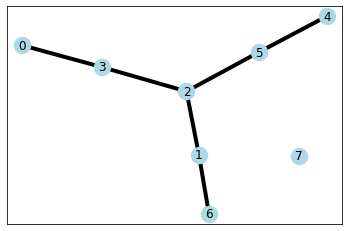

In [20]:
import matplotlib.pyplot as plt

links = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G) 

nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', linewidths=0.07) # draw nodes
nx.draw_networkx_edges(G, pos, edgelist=links, width=4)                                 # draw edges

# node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
# edge weight labels

edge_labels = nx.get_edge_attributes(G, "weight")

nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()

# van description
- id: unique id for the car
- path: queue that includes all nodes that are going to be visited
- S: schedule queue. It is a queue of tuples. Tuple has 3 items where:
    * `tuple[0]` passenger name
    * `tuple[1]` location point
    * `tuple[2]` status `0 = pickup` `1 = dropoff`

In [26]:
vans = [
    {'id':1,
    'path':[0,3,2],
    'S':[('p1',3,0),('p1',2,1)],
    'clients':1
    },
    {'id':2,
    'path':[2,5,4],
    'S':[('p2',5,0),('p2',4,1)],
    'clients':1
    }
]

print(vans[0]['path'])
print(vans[0]['path'])
vans[0]['path'].pop(0)
print(vans[0]['path'])

[0, 3, 2]
[0, 3, 2]
[3, 2]


In [27]:
#updates path for next points
def updatePath(van,newNodes):
    return van['path']+newNodes[1:]

def updateS(van):
    pass

def generateOrders():
    Q=[]
    #generate node
    #check if node connected and drivers can get there
    #if yes add to queue
    #else: pass

    return Q

#testing
van = updatePath(vans[0],[6,7,8,10])
print(van)

[3, 2, 7, 8, 10]


In [29]:
#find closest driver
d={}
for v in vans:
    if nx.has_path(G,v['path'][-1],6):
        cur = len(nx.shortest_path(G,v['path'][-1],6,weight='weight',method='dijkstra'))
        d[cur]=v
smallest_key = min(d.keys())
#closest driver is a van
van = d[smallest_key]
print(value)

#schedule pickups for a driver
#update path for a driver
#update vans array

{'id': 1, 'path': [3, 2], 'S': [('p1', 3, 0), ('p1', 2, 0)], 'clients': 1}
